# 2.1. Conformal prediction for classification problems - Python

## Mục lục

- <a href='#1'>1. Xây dựng bài toán và xử lý dữ liệu </a>
- <a href='#2'>2. Conformal Prediction tự cài đặt </a>
    - <a href='#2.1'>2.1. Phương pháp LAC </a>
    - <a href='#2.2'>2.2. Phương pháp Top-K </a>
    - <a href='#2.3'>2.3. Phương pháp APS (Adaptive Prediction Sets) </a>
- <a href='#3'>3. Conformal Prediction sử dụng thư viện MAPIE</a>
    - <a href='#3.1'>3.1. Phương pháp LAC </a>
    - <a href='#3.2'>3.2. Phương pháp Top-K </a>
    - <a href='#3.3'>3.3. Phương pháp APS (Adaptive Prediction Sets) </a>
- <a href='#4'>4. Tham khảo</a>


## Nhóm 4:
- Huỳnh Tiến Dũng - 21020007
- Hoàng Văn Nguyên - 21020370
- Vũ Quốc Tuấn - 21020033

## <a id='1'>1. Xây dựng bài toán và xử lý dữ liệu
    
**Yêu cầu**: Sử dụng bộ dữ liệu `huang-401.csv` để thực hiện conformal prediction, trong đó cần phỏng đoán biến
`phase` từ các biến `vec`, `delta`, `deltachi`, `deltahmix`, `deltasmix`. Giải thích chi tiết từng bước
thực hiện.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

Đọc dữ liệu đầu vào `data/huang-401.csv`

In [2]:
huang = pd.read_csv('data/huang-401.csv')
print("Shape:", huang.shape)
huang.head()

Shape: (401, 8)


,composition,vec,deltachi,delta,deltahmix,deltasmix,phase,reference
0,AgAlCoCrCuNi,8.34,0.129,6.59,2.00,14.90,SS+IM,[1]
1,AlAuCoCrCuNi,8.34,0.303,6.53,-6.45,14.90,SS+IM,[1]
2,AlCoCrCu0.5Fe,7.00,0.117,5.87,-6.12,13.14,SS+IM,[2]
3,AlCoCrCuFe,7.40,0.118,5.58,-2.56,13.38,SS+IM,[3]
4,AlCoCrCuFeMnNi,7.72,0.140,5.18,-5.64,16.18,SS+IM,[4]


Tiếp đến, xem các giá trị khác nhau của nhãn `phase` và tần suất xuất hiện của chúng.

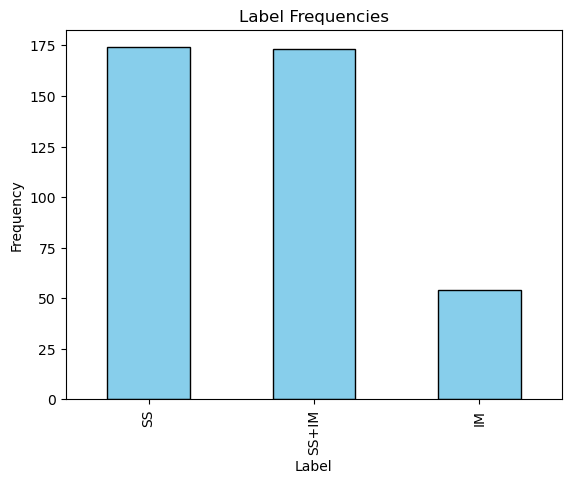

In [3]:
# Get the frequency of each label
label_counts = huang['phase'].value_counts()

# Plot the frequencies
label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Label Frequencies')

# Show the plot
plt.show()

Thực hiện label encoding, chuyển nhãn `phase` từ dạng xâu kí tự sang số nguyên như sau:
- `IM`: 0
- `SS`: 1
- `SS+IM`: 2

Tạo nhãn mới `phase_encoded` là số nguyên tương ứng của `phase`

In [4]:
from sklearn.preprocessing import LabelEncoder
# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the 'phase' column
huang['phase_encoded'] = le.fit_transform(huang['phase'].to_numpy())

# Display the mapping between original labels and encoded integers
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping: ", label_mapping)
huang.head()

Label Mapping:  {'IM': 0, 'SS': 1, 'SS+IM': 2}


,composition,vec,deltachi,delta,deltahmix,deltasmix,phase,reference,phase_encoded
0,AgAlCoCrCuNi,8.34,0.129,6.59,2.00,14.90,SS+IM,[1],2
1,AlAuCoCrCuNi,8.34,0.303,6.53,-6.45,14.90,SS+IM,[1],2
2,AlCoCrCu0.5Fe,7.00,0.117,5.87,-6.12,13.14,SS+IM,[2],2
3,AlCoCrCuFe,7.40,0.118,5.58,-2.56,13.38,SS+IM,[3],2
4,AlCoCrCuFeMnNi,7.72,0.140,5.18,-5.64,16.18,SS+IM,[4],2


Ta cần phỏng đoán biến `phase` (hay `phase_encoded`) từ các biến `vec`, `delta`, `deltachi`, `deltahmix`, `deltasmix`. Ta sẽ giữ lại những biến cần thiết và xây dựng dữ liệu tương ứng như sau:

In [5]:
X = huang[['vec', 'delta', 'deltachi', 'deltahmix', 'deltasmix']]
y = huang['phase_encoded']
print(y)
print(X.shape)

0      2
1      2
2      2
3      2
4      2
      ..
396    1
397    1
398    1
399    1
400    1
Name: phase_encoded, Length: 401, dtype: int64
(401, 5)


Sau đó, ta tách ra thành 3 tập dữ liệu là: tập train (80%), tập calibration (10%) và tập test (10%).

Nhiều tỉ lệ khác nhau đã được thử nhưng tỉ lệ 80-10-10 cho kết quả tốt nhất. Tập train có đủ nhiều dữ liệu để mô hình không bị overfit.

In [6]:
from sklearn.model_selection import train_test_split
seed = 42
# Split the data into training (80%), calibration + test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=seed)

# Split calibration + test into calibration (10%) and test (10%)
X_calibrate, X_test, y_calibrate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

# Display the shapes of the resulting sets
print("Training set - X:", X_train.shape, " y:", y_train.shape)
print("Calibration set - X:", X_calibrate.shape, " y:", y_calibrate.shape)
print("Test set - X:", X_test.shape, " y:", y_test.shape)

Training set - X: (320, 5)  y: (320,)
Calibration set - X: (40, 5)  y: (40,)
Test set - X: (41, 5)  y: (41,)


Sử dụng mô hình Random Forest Classifier cho bài toán (nhiều mô hình khác đã thử nhưng không cho kết quả tốt như Decision Tree, Gradient Boosting, Neural Network...). 

Sau đó, thử in độ chính xác của mô hình trên 3 tập dữ liệu. Ta dễ thấy do dữ liệu khá ít nên mô hình bị overfit ở tập train (độ chính xác 100%) và mô hình tệ hơn ở tập calibration và tập test.

In [7]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest Classifier
model = RandomForestClassifier(random_state=seed)

# Fit the model on the training data
model.fit(X_train, y_train)

# Calculate accuracy on the training set
y_train_pred = model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)
print("Training set accuracy:", accuracy_train)

# Calculate accuracy on the calibration set
y_cal_pred = model.predict(X_calibrate)
accuracy_cal = accuracy_score(y_calibrate, y_cal_pred)
print("Calibration set accuracy:", accuracy_cal)

# Calculate accuracy on the tebst set
y_test_pred = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Test set accuracy:", accuracy_test)

Training set accuracy: 1.0
Calibration set accuracy: 0.725
Test set accuracy: 0.5853658536585366


## <a id='2'>2. Conformal Prediction tự cài đặt

Các phương pháp được đề cập sau đây bao gồm:
- LAC
- Top-K
- APS (Adaptive Prediction Sets)

Ngoài ra, còn nhiều phương pháp khác không được để cập ở đây nhưng được tích hợp trong thư viện MAPIE như Regularized Adaptive Prediction Sets (RAPS), Split- and cross-conformal...
    
Nguồn tham khảo: [MAPIE - Theoretical Description Classification](https://mapie.readthedocs.io/en/latest/theoretical_description_classification.html) 

### <a id='2.1'>2.1. Phương pháp LAC 

Trong phương pháp LAC, "conformity score" $s_i$ được định nghĩa là 1 trừ điểm số của nhãn thực sự. Đối với mỗi quan sát $i$ trong tập calibration ($\hat{\mu}(X_i)_{Y_i}$ là xác suất của nhãn $Y_i$ mà mô hình dự đoán thông qua quan sát $X_i$):

$$s_i(X_i, Y_i) = 1 - \hat{\mu}(X_i)_{Y_i}$$

Khi các "conformity score" ${s_1, ..., s_n}$ được tính toán cho tất cả các quan sát, chúng ta tính giá trị $ (n+1)*(1-\alpha)/n$ quantile $\hat{q}$ theo công thức sau:

$$\hat{q} = Quantile \left(s_1, ..., s_n ; \frac{\lceil(n+1)(1-\alpha)\rceil}{n}\right)$$

Cuối cùng, chúng ta xây dựng một tập dự đoán bằng cách bao gồm tất cả các nhãn có điểm số cao hơn quantile ước lượng:

$$\hat{C}(X_{test}) = \{y : \hat{\mu}(X_{test})_y \geq 1 - \hat{q}\}$$

Phương pháp đơn giản này cho phép chúng ta xây dựng các tập dự đoán có đảm bảo lý thuyết về phủ biên. Tuy nhiên, mặc dù phương pháp này thường dẫn đến các tập dự đoán nhỏ, nó có xu hướng tạo ra các tập trống khi mô hình không chắc chắn, ví dụ như ở biên giữa hai lớp.

Ở phần cài đặt, đầu tiên, ta sẽ tính toán "conformity score" $s_i$ trên tập dữ liệu calibration.

In [8]:
# Size of calibration data
n = len(X_calibrate)

# Get the probability predictions on X_calibrate
preds = model.predict_proba(X_calibrate)

# Get the probability for the true class
prob_true = preds[np.arange(n), y_calibrate]

# Calculate non-conformity score s_i of the LAC method
scores = 1 - prob_true

preds[:5], prob_true[:5], scores[:5]

(array([[0.  , 0.08, 0.92],
        [0.  , 0.76, 0.24],
        [0.01, 0.12, 0.87],
        [0.39, 0.01, 0.6 ],
        [0.  , 0.2 , 0.8 ]]),
 array([0.92, 0.76, 0.87, 0.6 , 0.8 ]),
 array([0.08, 0.24, 0.13, 0.4 , 0.2 ]))

Tiếp theo, tính toán vị trí cut-off $\hat{q}$ thỏa mãn $90\%$ (tương ứng với $\alpha = 0.1$) số lượng $s_i$ là nhỏ hơn ($=90\%$ quantile). Sử dụng công thức $$q\_level = \dfrac{\left \lceil{(n + 1)} \cdot (1-\alpha)\right \rceil}{n}$$

In [9]:
alpha = 0.1
q_level = np.ceil((n+1) * (1-alpha)) / n
qhat = np.quantile(scores, q_level, method='lower')
qhat

0.69

Tạo tập dự đoán trên bộ test (`y_ps_score`), giữ lại các dự đoán mà có tỉ lệ không chắc chắn lớn hơn hoặc bằng $1 - \hat{q}$.

- `real` là nhãn đúng của tập test.
- `predset` là tập các nhãn mà mô hình dự đoán của tập test.
- `coverage[i]` $=1$ nếu nhãn đúng (`real[i]`) thuộc tập nhãn mà mô hình dự đoán (`predset[i]`), ngược lại $=0$.

In [10]:
y_ps_score = (model.predict_proba(X_test) >= 1 - qhat)

real = le.classes_[huang['phase_encoded'][y_test.index]]
predset = [''] * len(y_test)
coverage = [0] * len(y_test)
for i in range(len(y_test)):
    predset[i] = ','.join(le.classes_[y_ps_score[i]])
    if real[i] in le.classes_[y_ps_score[i]]:
        coverage[i] = 1
y_ps_score[:5], predset[:5]

(array([[ True, False, False],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True, False],
        [False, False,  True]]),
 ['IM', 'SS,SS+IM', 'SS,SS+IM', 'SS', 'SS+IM'])

Tổng hợp kết quả của conformal prediction như sau:

In [11]:
# Summarize the result of conformal prediction
result = pd.DataFrame(list(zip(real, predset, coverage)),
                  columns=['actual', 'predicted', 'coverage'])
result[:5]

,actual,predicted,coverage
0,SS,IM,0
1,SS+IM,"SS,SS+IM",1
2,SS+IM,"SS,SS+IM",1
3,SS,SS,1
4,IM,SS+IM,0


Tính toán độ phủ của tập dự đoán của mô hình trên tập test.

In [12]:
# Calculate coverage rate
print("Coverage rate =", sum(result.coverage)/len(result))

Coverage rate = 0.8292682926829268


### <a id='2.2'>2.2. Phương pháp Top-K 

Được giới thiệu trong <a href='#4'>[3]</a>, đặc điểm của phương pháp Top-K là nó sẽ cung cấp kích thước tập dự đoán giống nhau cho tất cả các quan sát. 

Giá trị "conformity score" là thứ hạng (rank) của nhãn đúng, với các điểm $\hat{\mu}(X_i)_{Y_i}$ được xếp hạng từ cao đến thấp. 

Các tập dự đoán được xây dựng bằng cách lấy $\hat{q}^{th}$ điểm số cao nhất. Quy trình được mô tả trong các phương trình sau:

$$s_i(X_i, Y_i) = j \quad \text{với} \quad Y_i = \pi_j \quad \text{vaf} \quad \hat{\mu}(X_i)_{\pi_1} > ... > \hat{\mu}(X_i)_{\pi_j} > ... > \hat{\mu}(X_i)_{\pi_n}$$

$$\hat{q} = \left \lceil Quantile \left(s_1, ..., s_n ; \frac{\lceil(n+1)(1-\alpha)\rceil}{n}\right) \right\rceil$$

$$\hat{C}(X_{test}) = \{\pi_1, ..., \pi_{\hat{q}}\}$$

Giống như các phương pháp khác, quy trình này cho phép người dùng xây dựng các tập dự đoán với đảm bảo về phủ biên.

In [13]:
def convert_to_ranks(arr):
    ranks = np.apply_along_axis(lambda x: (-x).argsort().argsort(), axis=1, arr=arr)

    return ranks

def get_topK(arr, q_hat):
    ranks = np.apply_along_axis(lambda x: (-x).argsort().argsort(), axis=1, arr=arr)

    topK = (ranks <= q_hat)

    return topK

In [14]:
# Size of calibration data
n = len(X_calibrate)

# Get the probability predictions on X_calibrate
preds = model.predict_proba(X_calibrate)

# Get the rank for the true class
ranks = convert_to_ranks(preds)

# Calculate non-conformity score s_i of the Top-K method
scores = ranks[np.arange(n), y_calibrate]

preds[:5], ranks[:5], scores[:5]

(array([[0.  , 0.08, 0.92],
        [0.  , 0.76, 0.24],
        [0.01, 0.12, 0.87],
        [0.39, 0.01, 0.6 ],
        [0.  , 0.2 , 0.8 ]]),
 array([[2, 1, 0],
        [2, 0, 1],
        [2, 1, 0],
        [1, 2, 0],
        [2, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [15]:
alpha = 0.1
q_level = np.ceil((n+1) * (1-alpha)) / n
qhat = np.ceil(np.quantile(scores, q_level, method='lower'))
qhat

1.0

In [16]:
y_pred = model.predict_proba(X_test)
y_ps_score = get_topK(y_pred, qhat)

real = le.classes_[huang['phase_encoded'][y_test.index]]
predset = [''] * len(y_test)
coverage = [0] * len(y_test)
for i in range(len(y_test)):
    predset[i] = ','.join(le.classes_[y_ps_score[i]])
    if real[i] in le.classes_[y_ps_score[i]]:
        coverage[i] = 1
y_pred[:5], y_ps_score[:5], predset[:5]

(array([[0.8 , 0.05, 0.15],
        [0.1 , 0.33, 0.57],
        [0.  , 0.57, 0.43],
        [0.02, 0.81, 0.17],
        [0.25, 0.1 , 0.65]]),
 array([[ True, False,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [ True, False,  True]]),
 ['IM,SS+IM', 'SS,SS+IM', 'SS,SS+IM', 'SS,SS+IM', 'IM,SS+IM'])

In [17]:
# Summarize the result of conformal prediction
result = pd.DataFrame(list(zip(real, predset, coverage)),
                  columns=['actual', 'predicted', 'coverage'])
result[:5]

,actual,predicted,coverage
0,SS,"IM,SS+IM",0
1,SS+IM,"SS,SS+IM",1
2,SS+IM,"SS,SS+IM",1
3,SS,"SS,SS+IM",1
4,IM,"IM,SS+IM",1


In [18]:
# Calculate coverage rate
print("Coverage rate =", sum(result.coverage)/len(result))

Coverage rate = 0.926829268292683


### <a id='2.3'>2.3. Phương pháp APS (Adaptive Prediction Sets)

Phương pháp được Adaptive Prediction Set (APS) vượt qua vấn đề gặp phải bởi phương pháp LAC thông qua việc xây dựng các tập dự đoán mà theo định nghĩa là không trống. Giá trị "conformal score" $s_i$ được tính bằng cách cộng tổng điểm số được xếp hạng của mỗi nhãn, từ cao đến thấp cho đến khi đạt đến nhãn thực sự của quan sát:

$$s_i(X_i, Y_i) = \sum^k_{j=1} \hat{\mu}(X_i)_{\pi_j} \quad \text{where} \quad Y_i = \pi_k$$

Sau đó, giá trị quantile $\hat{q}$ được tính theo cùng cách như phương pháp LAC. Đối với việc xây dựng các tập dự đoán cho một điểm kiểm thử mới, quy trình cùng với việc cộng tổng xếp hạng được áp dụng cho đến khi đạt đến giá trị quantile, như mô tả trong phương trình sau:

$$\hat{C}(X_{test}) = \{\pi_1, ..., \pi_k\} \quad \text{where} \quad k = \text{inf}\{k : \sum^k_{j=1} \hat{\mu}(X_{test})_{\pi_j} \geq \hat{q}\}$$

Mặc định, nhãn có tổng điểm số lớn hơn giá trị quantile sẽ được bao gồm trong tập dự đoán. Tuy nhiên, việc tính thêm có thể được chọn ngẫu nhiên dựa trên sự khác biệt giữa tổng điểm số tích lũy của nó và giá trị quantile để đảm bảo rằng phủ biên hiệu quả vẫn gần với phủ biên (marginal) mục tiêu. Đọc giả có thể đọc thêm <a href='#4'>[2, 3]</a> để biết thêm chi tiết về khía cạnh này.

In [19]:
def get_aps_scores(arr):
    full_scores = np.empty_like(arr)
    for i, row in enumerate(arr):
        sorted_arr = np.cumsum(np.sort(row)[::-1])
        temp = (-row).argsort()
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(len(row))
        cumul = sorted_arr[ranks]
        full_scores[i] = cumul
    return full_scores
def get_aps_y_ps_bool(arr, qhat):
    y_ps_bool = np.empty_like(arr, dtype=bool)
    for i, row in enumerate(arr):
        sorted_arr = np.cumsum(np.sort(row)[::-1])
        temp = (-row).argsort()
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(len(row))
        index = np.searchsorted(sorted_arr, qhat, side='left')
        y_ps_bool[i] = (ranks <= index)
    return y_ps_bool

In [20]:
from sklearn.utils import check_random_state
# Size of calibration data
n = len(X_calibrate)

# Get the probability predictions on X_calibrate
preds = model.predict_proba(X_calibrate)

# Get the cumulative scores of all labels
full_scores = get_aps_scores(preds)

# Calculate non-conformity score s_i of the APS method
scores = full_scores[np.arange(n), y_calibrate]

# Apply random noise for tie-breaking
random_state = check_random_state(seed)
u = random_state.uniform(size=len(scores))
prob_true = preds[np.arange(n), y_calibrate]
scores -= u * prob_true

preds[:5], full_scores[:5], scores[:5]

(array([[0.  , 0.08, 0.92],
        [0.  , 0.76, 0.24],
        [0.01, 0.12, 0.87],
        [0.39, 0.01, 0.6 ],
        [0.  , 0.2 , 0.8 ]]),
 array([[1.  , 1.  , 0.92],
        [1.  , 0.76, 1.  ],
        [1.  , 0.99, 0.87],
        [0.99, 1.  , 0.6 ],
        [1.  , 1.  , 0.8 ]]),
 array([0.57542309, 0.03745713, 0.23316527, 0.24080491, 0.67518509]))

In [21]:
alpha = 0.1
q_level = np.ceil((n+1) * (1-alpha)) / n
qhat = np.quantile(scores, q_level, method='lower')
qhat

0.8668380552278118

In [22]:
y_pred = model.predict_proba(X_test)
y_ps_bool = get_aps_y_ps_bool(y_pred, qhat)
real = le.classes_[huang['phase_encoded'][y_test.index]]
predset = [''] * len(y_test)
coverage = [0] * len(y_test)
for i in range(len(y_test)):
    predset[i] = ','.join(le.classes_[y_ps_bool[i]])
    if real[i] in le.classes_[y_ps_bool[i]]:
        coverage[i] = 1
y_pred[:5], y_ps_bool[:5], predset[:5]

(array([[0.8 , 0.05, 0.15],
        [0.1 , 0.33, 0.57],
        [0.  , 0.57, 0.43],
        [0.02, 0.81, 0.17],
        [0.25, 0.1 , 0.65]]),
 array([[ True, False,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [ True, False,  True]]),
 ['IM,SS+IM', 'SS,SS+IM', 'SS,SS+IM', 'SS,SS+IM', 'IM,SS+IM'])

In [23]:
# Summarize the result of conformal prediction
result = pd.DataFrame(list(zip(real, predset, coverage)),
                  columns=['actual', 'predicted', 'coverage'])
result[:5]

,actual,predicted,coverage
0,SS,"IM,SS+IM",0
1,SS+IM,"SS,SS+IM",1
2,SS+IM,"SS,SS+IM",1
3,SS,"SS,SS+IM",1
4,IM,"IM,SS+IM",1


In [24]:
# Calculate coverage rate
print("Coverage rate =", sum(result.coverage)/len(result))

Coverage rate = 0.975609756097561


## <a id='3'>3. Conformal Prediction sử dụng thư viện MAPIE

### <a id='3.1'>3.1. Phương pháp LAC

In [25]:
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score

Sử dụng `model` đã xây dựng ở trên, ta sử dụng thư viện MAPIE để thực hiện conformal prediction. Sử dụng phương pháp `method="lac"` tương tự như phương pháp tự cài đặt ở mục <a href='#2.1'>2.1</a>. MAPIE cung cấp nhiều phương pháp khác như `aps`, `raps`, `top_k`.

Sử dụng cùng $\alpha=0.1$, ta fit mô hình MAPIE với tập calibrate và dự đoán trên tập test để nhận được `y_ps_score` (tương tự với `y_ps_score` đã được tính ở phần tự cài đặt trên).

In [26]:
mapie_score = MapieClassifier(estimator=model, cv="prefit", method="lac", verbose=100, random_state=seed)
mapie_score.fit(X_calibrate, y_calibrate)
alpha = 0.1
y_pred_score, y_ps_score = mapie_score.predict(X_test, alpha=alpha)
y_ps_score = np.squeeze(y_ps_score)
y_ps_score[:5]

array([[ True, False, False],
       [False,  True,  True],
       [False,  True,  True],
       [False,  True, False],
       [False, False,  True]])

Tổng hợp kết quả tương tự như ở phần trên ta được:

In [27]:
real = le.classes_[huang['phase_encoded'][y_test.index]]
predset = ['']*len(y_test)
coverage = [0]*len(y_test)
for i in range(len(y_test)):
    predset[i] = ','.join(le.classes_[y_ps_score[i]])
    if real[i] in le.classes_[y_ps_score[i]]:
        coverage[i] = 1

In [28]:
# Summarize the result of conformal prediction
result = pd.DataFrame(list(zip(real, predset, coverage)),
                  columns=['actual', 'predicted', 'coverage'])
result[:5]

,actual,predicted,coverage
0,SS,IM,0
1,SS+IM,"SS,SS+IM",1
2,SS+IM,"SS,SS+IM",1
3,SS,SS,1
4,IM,SS+IM,0


Độ phủ coverage rate tính được sử dụng thư viện MAPIE bằng với phương pháp tự cài đặt ở trên.

In [29]:
print(classification_coverage_score(y_test, y_ps_score))

0.8292682926829268


### <a id='3.2'>3.2. Phương pháp Top-K

Tương tự như đã cài đặt ở mục <a href='#2.2'>2.2</a>.

In [30]:
mapie_score = MapieClassifier(estimator=model, cv="prefit", method="top_k", verbose=100, random_state=seed)
mapie_score.fit(X_calibrate, y_calibrate)
alpha = 0.1
y_pred_score, y_ps_score = mapie_score.predict(X_test, alpha=alpha)
y_ps_score = np.squeeze(y_ps_score)

y_ps_score[:5], y_pred_score[:5]

(array([[ True, False,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [ True, False,  True]]),
 array([0, 2, 1, 1, 2]))

In [31]:
real = le.classes_[huang['phase_encoded'][y_test.index]]
predset = ['']*len(y_test)
coverage = [0]*len(y_test)
for i in range(len(y_test)):
    predset[i] = ','.join(le.classes_[y_ps_score[i]])
    if real[i] in le.classes_[y_ps_score[i]]:
        coverage[i] = 1
        
# Summarize the result of conformal prediction
result = pd.DataFrame(list(zip(real, predset, coverage)),
                  columns=['actual', 'predicted', 'coverage'])
result[:5]

,actual,predicted,coverage
0,SS,"IM,SS+IM",0
1,SS+IM,"SS,SS+IM",1
2,SS+IM,"SS,SS+IM",1
3,SS,"SS,SS+IM",1
4,IM,"IM,SS+IM",1


In [32]:
print(classification_coverage_score(y_test, y_ps_score))

0.926829268292683


### <a id='3.3'>3.3. Phương pháp APS (Adaptive Prediction Sets)

Tương tự như đã cài đặt ở mục <a href='#2.3'>2.3</a>.

In [33]:
mapie_score = MapieClassifier(estimator=model, cv="prefit", method="aps", verbose=100, random_state=seed)
mapie_score.fit(X_calibrate, y_calibrate)
alpha = 0.1
y_pred_score, y_ps_score = mapie_score.predict(X_test, alpha=alpha)
y_ps_score = np.squeeze(y_ps_score)

y_ps_score[:5], y_pred_score[:5]

(array([[ True, False,  True],
        [False,  True,  True],
        [False,  True,  True],
        [False,  True,  True],
        [ True, False,  True]]),
 array([0, 2, 1, 1, 2]))

In [34]:
real = le.classes_[huang['phase_encoded'][y_test.index]]
predset = ['']*len(y_test)
coverage = [0]*len(y_test)
for i in range(len(y_test)):
    predset[i] = ','.join(le.classes_[y_ps_score[i]])
    if real[i] in le.classes_[y_ps_score[i]]:
        coverage[i] = 1
        
# Summarize the result of conformal prediction
result = pd.DataFrame(list(zip(real, predset, coverage)),
                  columns=['actual', 'predicted', 'coverage'])
result[:5]

,actual,predicted,coverage
0,SS,"IM,SS+IM",0
1,SS+IM,"SS,SS+IM",1
2,SS+IM,"SS,SS+IM",1
3,SS,"SS,SS+IM",1
4,IM,"IM,SS+IM",1


In [35]:
print(classification_coverage_score(y_test, y_ps_score))

0.975609756097561


## <a id='4'>4. Tham khảo
    
- [MAPIE - Theoretical Description Classification](https://mapie.readthedocs.io/en/latest/theoretical_description_classification.html)
- [1] Mauricio Sadinle, Jing Lei, & Larry Wasserman. “Least Ambiguous Set-Valued Classifiers With Bounded Error Levels.” Journal of the American Statistical Association, 114:525, 223-234, 2019.
- [2] Yaniv Romano, Matteo Sesia and Emmanuel J. Candès. “Classification with Valid and Adaptive Coverage.” NeurIPS 202 (spotlight), 2020.
- [3] Anastasios Nikolas Angelopoulos, Stephen Bates, Michael Jordan and Jitendra Malik. “Uncertainty Sets for Image Classifiers using Conformal Prediction.” International Conference on Learning Representations 2021.